In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle

In [3]:
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params

In [5]:
with open('config.json') as file:
    config = json.load(file)

In [6]:
files_folder = config['files_folders']['processed']
research_results_folder = config['files_folders']['research_results']

# RTS index

## Reading files

In [7]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [8]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

## Setting parameters & data

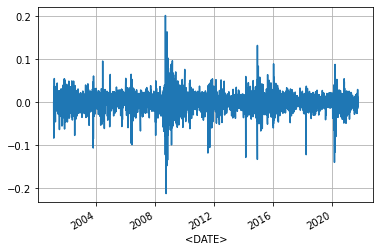

In [9]:
rtsi['log return'].plot()

plt.grid()
plt.show()

In [10]:
rescale_factor = 100
start_date = '2014-01-01'

input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

In [11]:
n = input_data.shape[0]

In [12]:
n

1964

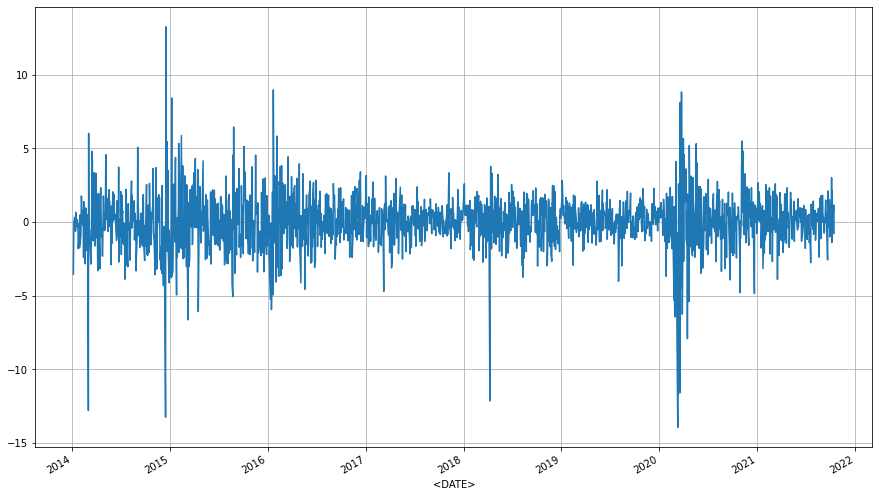

In [13]:
input_data.plot(figsize=(15, 9))

plt.grid()
plt.show()

In [14]:
input_data.describe()

count    1964.000000
mean        0.013812
std         1.826568
min       -13.948614
25%        -0.899103
50%         0.071543
75%         0.935148
max        13.246192
Name: log return, dtype: float64

In [15]:
days_of_week = pd.Series(input_data.index.dayofweek, index=input_data.index, name='day of week').copy()

### train & test split 

In [16]:
input_data.shape

(1964,)

In [17]:
n_train = 250  # 2000
n_test = min(n - n_train, 100)

In [18]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

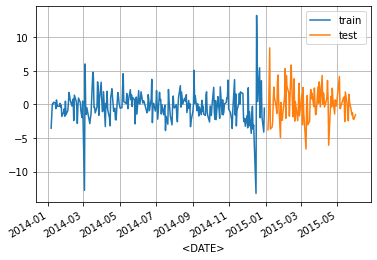

In [19]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [20]:
train.describe()

count    250.000000
mean      -0.240386
std        2.418315
min      -13.254545
25%       -1.476669
50%       -0.240821
75%        0.751304
max       13.246192
Name: log return, dtype: float64

### Setting consequent meta parameters

In [21]:
# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

In [22]:
train_sample_std

2.418315232036241

In [23]:
first_h

array([5.84824856])

#### Using classic GARCH to get initial parameters values

In [24]:
garch_mean = 'Zero'
garch_dist = 'normal'

garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 187608058.86123785
Iteration:      2,   Func. Count:     10,   Neg. LLF: 594.1464784705709
Iteration:      3,   Func. Count:     15,   Neg. LLF: 542.6512391591452
Iteration:      4,   Func. Count:     20,   Neg. LLF: 543.469201503261
Iteration:      5,   Func. Count:     25,   Neg. LLF: 541.0798283261172
Iteration:      6,   Func. Count:     29,   Neg. LLF: 541.0743375801683
Iteration:      7,   Func. Count:     33,   Neg. LLF: 541.073858696034
Iteration:      8,   Func. Count:     37,   Neg. LLF: 541.0738440829475
Iteration:      9,   Func. Count:     40,   Neg. LLF: 541.073844082923
Optimization terminated successfully    (Exit mode 0)
            Current function value: 541.0738440829475
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9


In [25]:
garch_fitted.params

omega       1.441062
alpha[1]    0.236592
beta[1]     0.485575
Name: params, dtype: float64

In [26]:
alpha_0_ini_vanilla = garch_fitted.params.iloc[0]
alpha_ini_vanilla = garch_fitted.params.iloc[1:(q + 1)].values
beta_ini_vanilla = garch_fitted.params.iloc[(q + 1):].values

In [27]:
consequent_params_ini_vanilla = {'alpha_0': alpha_0_ini_vanilla, 'alpha': alpha_ini_vanilla, 'beta': beta_ini_vanilla}

#### Setting dict w/ all consequent meta parameters

In [28]:
consequent_parameters = {'p': p, 'q': q, 'first_h': first_h}

##### `parameters_ini` and `bounds` not yet set!

## Modeling

### 2 clusters

#### setting clusterization (antecedent) parameters

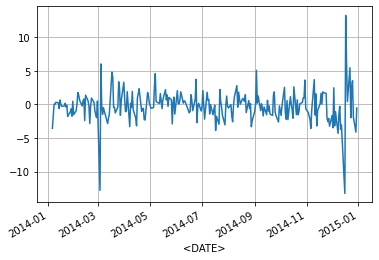

In [29]:
train.plot()

plt.grid()
plt.show()

In [30]:
clusterization_method = 'gaussian'

n_clusters = 4

centers = [-10, -2, 3, 7.5]
variances = [4, 4, 4, 4]

clusterization_parameters = {'centers': centers, 'variances': variances, 'n_clusters': n_clusters}

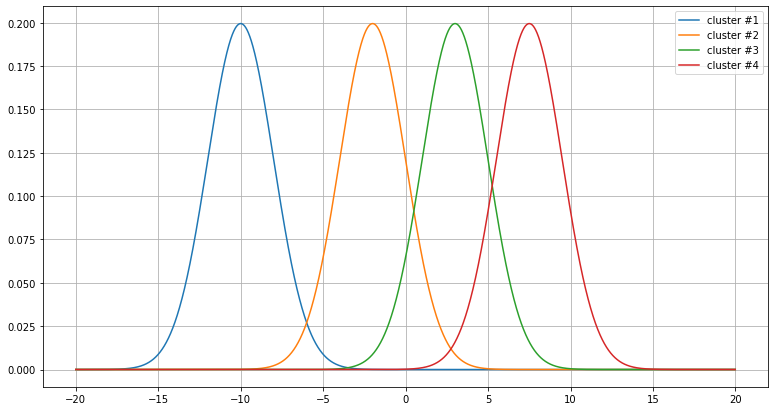

In [31]:
plt.figure(figsize=(13, 7))

for i in range(n_clusters):
    _range = np.arange(-20, 20, .01)
    _data = sts.norm(centers[i], variances[i] ** .5).pdf(_range)
    
    plt.plot(_range, _data, label=f'cluster #{i + 1}')
   
plt.legend()
plt.grid()
plt.show()

#### setting `parameters_ini` in consequent

In [32]:
alpha_0_ini = np.array([alpha_0_ini_vanilla] * n_clusters)
alpha_ini = np.array([alpha_ini_vanilla] * n_clusters).T
beta_ini = np.array([beta_ini_vanilla] * n_clusters).T

parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

consequent_parameters['parameters_ini'] = parameters_ini

In [33]:
parameters_ini

{'alpha_0': array([1.44106153, 1.44106153, 1.44106153, 1.44106153]),
 'alpha': array([[0.23659162, 0.23659162, 0.23659162, 0.23659162]]),
 'beta': array([[0.48557484, 0.48557484, 0.48557484, 0.48557484]])}

#### setting consequent parameters constraints (passed to LS)

In [34]:
lower_bounds = [0] * ((1 + p + q) * n_clusters)
upper_bounds = [+np.inf] * n_clusters + [1] * ((p + q) * n_clusters)
bounds = (lower_bounds, upper_bounds)

consequent_parameters['bounds'] = bounds

#### creating model instance

In [35]:
# logging.basicConfig(level=logging.DEBUG)

In [36]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_method,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=consequent_parameters,
                           data_to_cluster='train')

##### fitting

In [39]:
%%time

fvm.fit()

CPU times: user 48.1 s, sys: 832 ms, total: 48.9 s
Wall time: 27.2 s


##### testing

In [ ]:
# n_test = 20

# test = test.iloc[:n_test].copy()
# input_cut = pd.concat([train, test]).copy()

# data_to_cluster_test = data_to_cluster_test.iloc[:n_test].copy()

In [40]:
test.shape

(100,)

In [41]:
%%time

fvm.feed_daily_data(test, data_to_cluster=None)

CPU times: user 1h 30min 13s, sys: 1min 20s, total: 1h 31min 33s
Wall time: 57min 3s


In [42]:
cur_time = pd.Timestamp.today()
print(cur_time)
with open(f'{research_results_folder}/fvm_{cur_time}.pkl', 'wb') as file:
    pickle.dump(fvm, file)

2022-01-20 17:31:45.884512


In [43]:
len(fvm._hist_output)

101

In [44]:
fvm.hist_output.shape

(100,)

In [45]:
# (fvm.rules_outputs_hist[0] == fvm.rules_outputs_hist[1]).all()

In [46]:
fvm.clusters_parameters_hist

,centers,variances,n_clusters
<DATE>,,,
2015-01-05,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2015-01-06,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2015-01-08,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2015-01-09,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2015-01-12,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
...,...,...,...
2015-05-26,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2015-05-27,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4
2015-05-28,"[-10, -2, 3, 7.5]","[4, 4, 4, 4]",4


#### Plots

In [47]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [48]:
simple_garch_forecasts

array([5.68439664, 5.54614214, 5.44629939, 5.37419629, 5.32212586,
       5.28452234, 5.25736634, 5.23775518, 5.22359266, 5.21336497,
       5.20597887, 5.20064488, 5.19679285, 5.19401104, 5.19200211,
       5.19055133, 5.18950363, 5.18874701, 5.18820061, 5.18780601,
       5.18752105, 5.18731526, 5.18716664, 5.18705932, 5.18698181,
       5.18692584, 5.18688542, 5.18685623, 5.18683515, 5.18681992,
       5.18680893, 5.18680099, 5.18679525, 5.18679111, 5.18678812,
       5.18678596, 5.1867844 , 5.18678328, 5.18678246, 5.18678188,
       5.18678145, 5.18678115, 5.18678093, 5.18678077, 5.18678065,
       5.18678057, 5.18678051, 5.18678046, 5.18678043, 5.18678041,
       5.18678039, 5.18678038, 5.18678037, 5.18678037, 5.18678036,
       5.18678036, 5.18678036, 5.18678036, 5.18678035, 5.18678035,
       5.18678035, 5.18678035, 5.18678035, 5.18678035, 5.18678035,
       5.18678035, 5.18678035, 5.18678035, 5.18678035, 5.18678035,
       5.18678035, 5.18678035, 5.18678035, 5.18678035, 5.18678

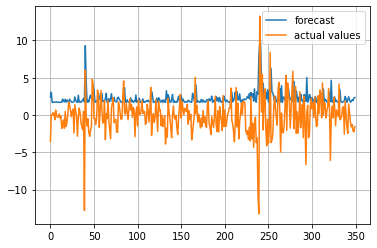

In [49]:
plt.plot(fvm.h[:-1] ** .5, label='forecast')
plt.plot(input_cut.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

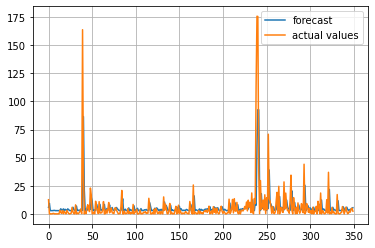

In [50]:
plt.plot(fvm.h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

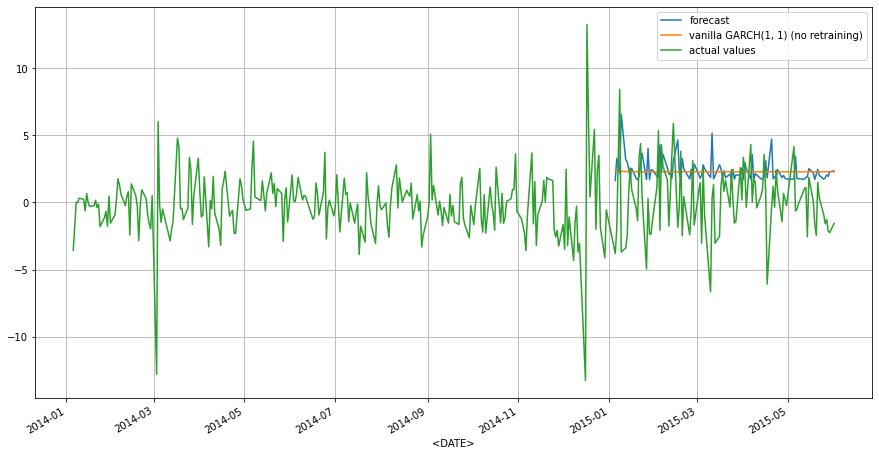

In [51]:
(fvm.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvm.hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

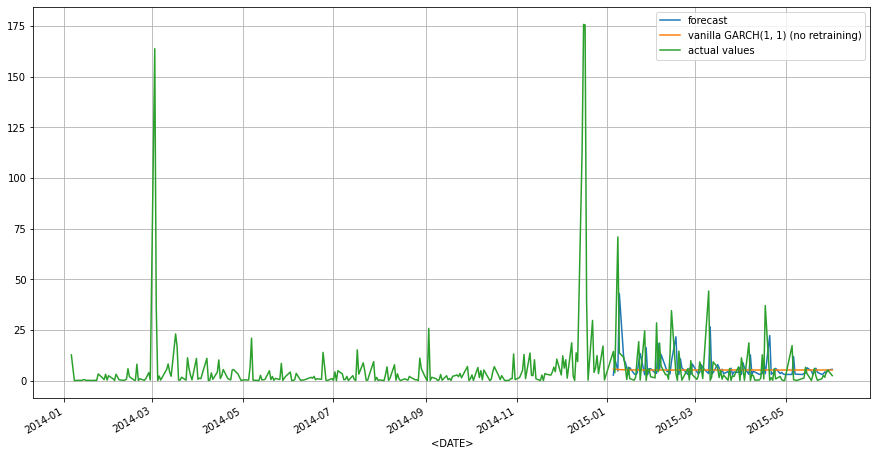

In [52]:
fvm.hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvm.hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

#### Errors

##### my model

In [54]:
mean_squared_error(fvm.hist_output, test ** 2, squared=True)

145.23894978061329464

In [55]:
mean_squared_error(fvm.hist_output, test ** 2, squared=False)

12.051512344125665569

In [56]:
mean_absolute_percentage_error(fvm.hist_output, test ** 2)

1.4487057043448989263

##### GARCH (no retraining)

In [57]:
mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)

108.33138235421401

In [58]:
mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)

10.408236274903352

In [59]:
mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

1.1293418560010313

# Trying to find the best antecedent parameters

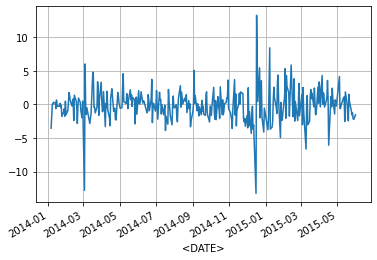

In [34]:
input_cut.plot()

plt.grid()
plt.show()

In [35]:
clusterization_method = 'gaussian'
antecedent_params_set = []

In [36]:
# new params
n_clusters = 4

centers = [-10, -2, 3, 7.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-8, -2, 3, 7.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-12, -2, 3, 7.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-10, -2, 3, 9.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-8, -2, 3, 9.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-12, -2, 3, 9.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-10, -2, 3, 5.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-8, -2, 3, 5.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

# new params
n_clusters = 4

centers = [-12, -2, 3, 5.5]
variances = [4, 4, 4, 4]

antecedent_params_set.append({'centers': centers, 'variances': variances, 'n_clusters': n_clusters})

In [37]:
result = None

In [ ]:
%%time

result = fit_antecedent_params(train, test,
                               consequent_metaparams=consequent_parameters,
                               consequent_params_ini=consequent_params_ini_vanilla,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train='train', data_to_cluster_test=None)

In [40]:
result

{'fvms': [<model.FuzzyVolatilityModel at 0x2b517b5f7580>],
 'mses': [23.001731448249820189],
 'mapes': [1.099113665034105907]}

In [43]:
fvms = result['fvms']

In [41]:
result['mses']

[23.001731448249820189]

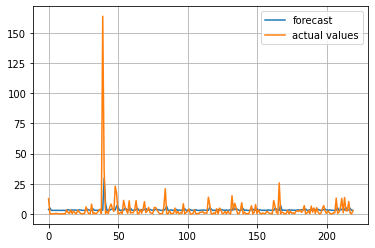

In [76]:
plt.plot(fvms[0].h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

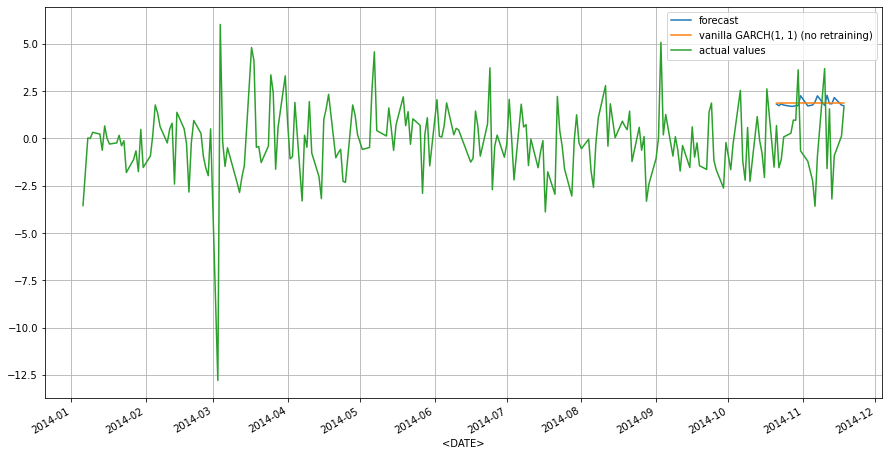

In [77]:
(fvms[0].hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

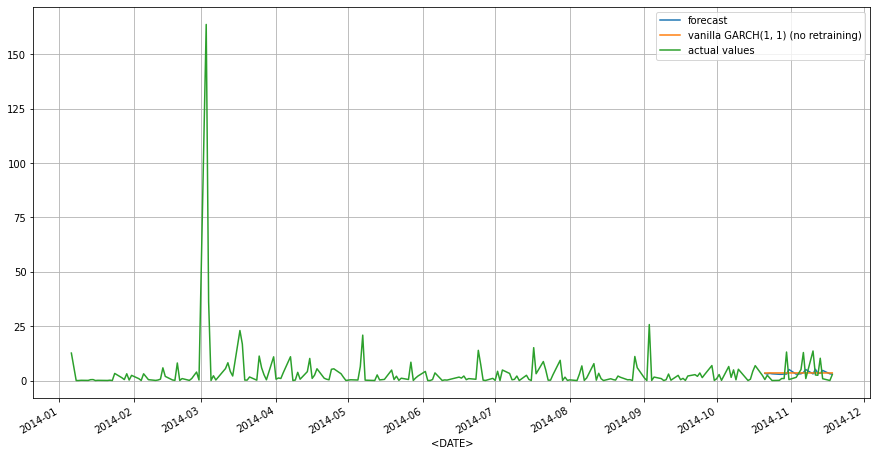

In [57]:
fvms[0].hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()